# Conversion to ONNX

Cool request and which resulted in exploration lol.
Thanks [Chriamue from Hugging Face](https://huggingface.co/dennisjooo/Birds-Classifier-EfficientNetB2/discussions/1).

Turns out it's not as straight forward because a direct conversion from EfficientNet HF model to a ONNX model isn't supported by Optimum yet.

## Imports and all that fun stuff

### Installing the things we need
I used colab for this, there are a couple of things you need to install, first of all, the protobuf-compiler and libprotoc-dev, which are needed for the onnx conversion.

In [ ]:
# Install ONNX in Colab
!sudo apt-get install protobuf-compiler libprotoc-dev
!pip -qq install onnx

Next the colab environment is pre-installed with PyTorch for CUDA, so we need to install the CPU version of PyTorch. We'll also install transformers to download the model from the Hugging Face model hub as well as Optimum for the conversion, specifically the onnxruntime version.

In [1]:
# Installing the CPU version of torch
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu

# Installing Huggingface's transformers and optimum
!pip -qq install transformers
!pip -qq install optimum["onnxruntime"]

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
protobuf-compiler is already the newest version (3.12.4-1ubuntu7.22.04.1).
The following additional packages will be installed:
  libprotobuf-dev libprotobuf-lite23
The following NEW packages will be installed:
  libprotobuf-dev libprotobuf-lite23 libprotoc-dev
0 upgraded, 3 newly installed, 0 to remove and 18 not upgraded.
Need to get 2,554 kB of archives.
After this operation, 19.0 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libprotobuf-lite23 amd64 3.12.4-1ubuntu7.22.04.1 [209 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libprotobuf-dev amd64 3.12.4-1ubuntu7.22.04.1 [1,347 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libprotoc-dev amd64 3.12.4-1ubuntu7.22.04.1 [999 kB]
Fetched 2,554 kB in 1s (1,844 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like

### Importing the things we need
Next, just load the things we've installed.

In [2]:
# Importing modules to load the model and preprocessor from HF
from transformers import EfficientNetForImageClassification, EfficientNetImageProcessor, AutoConfig

# Importing torch goodies
import torch
import torch.nn as nn

# Importing ONNX and HF's ONNX inference
import onnx
import onnxruntime as ort
from optimum.onnxruntime import ORTModelForImageClassification
from optimum.pipelines import pipeline

# Importing stuff to visualise the end result
from PIL import Image
import os
import matplotlib.pyplot as plt
import numpy as np

## Model conversion

### Loading the model

First and foremost, let's load the model from the Hugging Face model hub.

In [ ]:
# Loading in the model from HF
model = EfficientNetForImageClassification.from_pretrained("dennisjooo/Birds-Classifier-EfficientNetB2")

### Explicit paddding

Next up, I found that the model architecture is not supported by Optimum, so we need to modify the architecture a bit. The biggest issue is that the padding mode is not supported, i.e. `padding_mode='same'`, thus we'll need to recalculate the padding for each layer that uses it. I used [RedEyed's function from StackOverflow](https://stackoverflow.com/questions/68565147/pytorch-unable-to-export-trained-model-as-onnx). 

Additionally, I found that `padding_mode='valid'` needed to be explicitly set to (0, 0).

In [4]:
# Calculating the padding size (since the HF model contains a lot of Conv2D with 'same' padding)
# Taken from RedEyed's answer in https://stackoverflow.com/questions/68565147/pytorch-unable-to-export-trained-model-as-onnx

def calc_same_padding(kernel_size, stride, input_size):
    if isinstance(kernel_size, tuple):
        kernel_size = kernel_size[0]

    if isinstance(stride, tuple):
        stride = stride[0]

    if isinstance(input_size, tuple):
        input_size = input_size[0]

    pad = ((stride - 1) * input_size - stride + kernel_size) / 2
    return (int(pad), int(pad))

def replace_conv2d_with_same_padding(m: nn.Module, input_size=512):
    if isinstance(m, nn.Conv2d):
        if m.padding == "same":
            m.padding = calc_same_padding(
                kernel_size=m.kernel_size,
                stride=m.stride,
                input_size=input_size
            )

        # I figured out that this somehow made the ONNX converter run, basically it's just a strict no padding
        elif m.padding == 'valid':
            m.padding = (0, 0)

In [29]:
# Setting the model into evaluation mode
model.eval()

# Applying the stuff made above
model = model.apply(lambda m: replace_conv2d_with_same_padding(m, 224))

### Adaptive pooling
Another issue I found was `avg_pool2d` can be a bastard, so I just replaced it with `AdaptiveAvgPool2d` which is supported by Optimum. Thankfully this should not affect the model's performance since that layer is not trainable.

In [ ]:
# Also found out that avg_pool2d causes error, can be replaced with this AdaptiveAvgPool2d
# It's not "learned" and it also squishes the tensor to the right dimension
model.efficientnet.pooler = nn.AdaptiveAvgPool2d(output_size=1)

## Conversion

### Converting to ONNX
Huff huff, we're almost there. Now we just need to convert the model to ONNX. I don't  really know what most of the parameters are, especially opset_version is, but I used version 9 since that's what the Torch documentation used. 

What I realised was `dynamic_axes` can be used to determine which axes are dynamic, i.e. can change in size, and which are static. I used this to set the batch axis as dynamic, since the batch size can change, and the rest as static.

In [12]:
# Creating a dir called model to save the onnx version
%mkdir model

# Exporting the model
torch.onnx.export(model,               # model being run
                  torch.randn(1, 3, 260, 260),   # model input (or a tuple for multiple inputs)
                  "model/birds-classifier-efficientnetb2.onnx",   # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=9,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['pixel_values'],   # the model's input names
                  output_names = ['logits'], # the model's logits names
                  dynamic_axes={'pixel_values' : {0 : 'batch_size'},    # variable length axes
                                'logits' : {0 : 'batch_size'}},
                  training=torch.onnx.TrainingMode.EVAL,
                  )

============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



### Loading the ONNX model
Finally, we load the ONNX model and check if it works, which it does! Yay!

We can also check the computational graph of the model to see if it's correct, which I honestly don't know how to read, but it looks cool.

In [41]:
# Loading the ONNX model
model_o = onnx.load("model/birds-classifier-efficientnetb2.onnx")

# Checking that the model is well formed
onnx.checker.check_model(model_o)

# Printing a human readable representation of the graph
print(onnx.helper.printable_graph(model_o.graph))

graph torch_jit (
  %pixel_values[FLOAT, batch_sizex3x260x260]
) initializers (
  %efficientnet.encoder.blocks.0.squeeze_excite.reduce.weight[FLOAT, 8x32x1x1]
  %efficientnet.encoder.blocks.0.squeeze_excite.reduce.bias[FLOAT, 8]
  %efficientnet.encoder.blocks.0.squeeze_excite.expand.weight[FLOAT, 32x8x1x1]
  %efficientnet.encoder.blocks.0.squeeze_excite.expand.bias[FLOAT, 32]
  %efficientnet.encoder.blocks.1.squeeze_excite.reduce.weight[FLOAT, 4x16x1x1]
  %efficientnet.encoder.blocks.1.squeeze_excite.reduce.bias[FLOAT, 4]
  %efficientnet.encoder.blocks.1.squeeze_excite.expand.weight[FLOAT, 16x4x1x1]
  %efficientnet.encoder.blocks.1.squeeze_excite.expand.bias[FLOAT, 16]
  %efficientnet.encoder.blocks.2.squeeze_excite.reduce.weight[FLOAT, 4x96x1x1]
  %efficientnet.encoder.blocks.2.squeeze_excite.reduce.bias[FLOAT, 4]
  %efficientnet.encoder.blocks.2.squeeze_excite.expand.weight[FLOAT, 96x4x1x1]
  %efficientnet.encoder.blocks.2.squeeze_excite.expand.bias[FLOAT, 96]
  %efficientnet.encoder

## Checking if the thing still work

### ORT session

We can now load the model into an ORT session and check if it works. We can also check the input and output names, which are `input_ids` and `logits` respectively. Let's give it a try on a random input.

In [39]:
# Creating an ORT inference session
ort_session = ort.InferenceSession("model/birds-classifier-efficientnetb2.onnx", providers=['CPUExecutionProvider'])

# Running an input through the model
outputs = ort_session.run(
    None,
    {"pixel_values": np.random.randn(10, 3, 260, 260).astype(np.float32)},
)

# Printing the output
print(outputs[0])

[[ 2.5581005   0.4480939   1.8608063  ...  4.00183     1.6038742
  10.505807  ]
 [ 2.7691646   0.6599221   1.9201448  ...  4.2995796   1.7002702
  10.894267  ]
 [ 2.718375    0.58007085  2.028774   ...  4.519371    1.9452293
  11.297108  ]
 ...
 [ 2.515278    0.54604226  1.7319913  ...  4.224949    1.379953
  10.95697   ]
 [ 2.541707    0.3234174   1.7595174  ...  4.3117146   1.6822777
  11.202993  ]
 [ 2.6778543   0.7336247   2.062326   ...  4.3585234   1.7799278
  10.712921  ]]


### HF inference

HuggingFace's modules can also use ONNX models, so let's try that out as well. There are a couple of things we need to do first though, like downloading the model's configuration (which is needed for converting classes to index, etc.) and the image processor.

In [25]:
# Downloading the config and preprocessor from HF
config = AutoConfig.from_pretrained('dennisjooo/Birds-Classifier-EfficientNetB2')
processor = EfficientNetImageProcessor.from_pretrained("dennisjooo/Birds-Classifier-EfficientNetB2")

# Using the HF ORT modules for inference
model_hf = ORTModelForImageClassification.from_pretrained(model_id='model/',
                                                          config=config)

The ONNX file Birds-Classifier-EfficientNetB2.onnx is not a regular name used in optimum.onnxruntime, the ORTModel might not behave as expected.


In [30]:
# Loading the image
test_dir = "./test_images/"
images = [Image.open(os.path.join(test_dir, path)) for path in os.listdir(test_dir)]

In [27]:
# Getting the logits
logits = model_hf(processor(images, return_type='np')['pixel_values'])['logits']

# Converting the logits into labels
labels = [model_hf.config.id2label[i] for i in np.argmax(logits, axis=-1)]

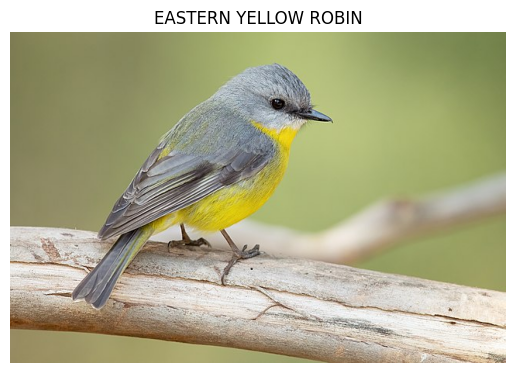

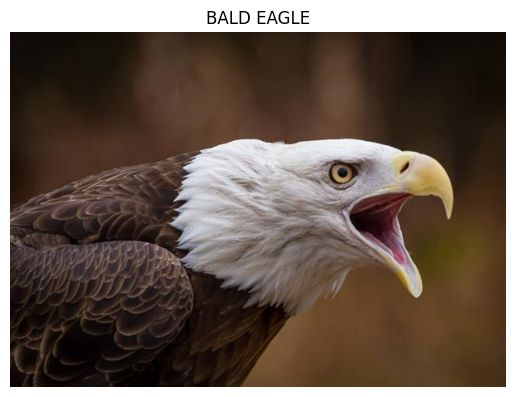

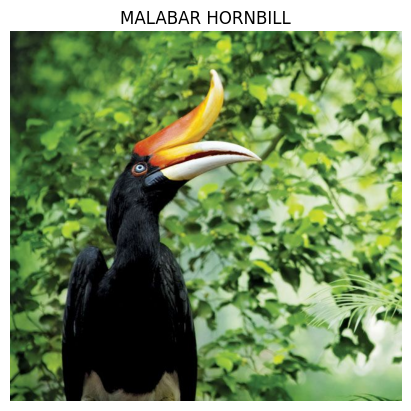

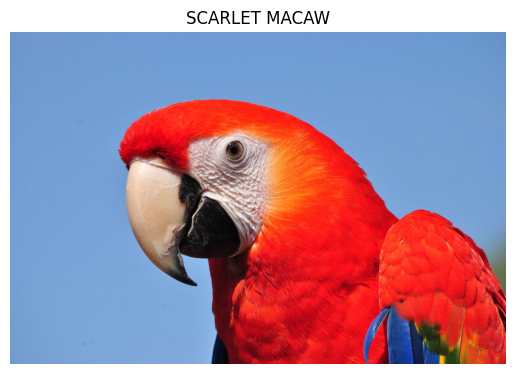

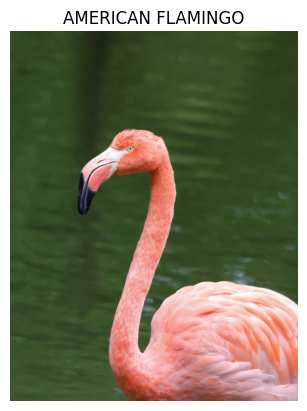

In [33]:
# Sanity check because I'm going mad
for i, image in enumerate(images):
    plt.imshow(image)
    plt.title(labels[i])
    plt.axis("off")
    plt.show()